# Scratch Notebook

In [88]:
%load_ext autoreload

import sys
import copy
import os
import json_tricks as json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", False)
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import optax
import matplotlib.pyplot as plt
import time

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot


from nvgd.src import utils, metrics, plot, stein, kernels, distributions, nets, models
from nvgd.experiments import bnn, dataloader

from jax.experimental import optimizers

key = random.PRNGKey(0)
key, subkey = random.split(key)

from jax.scipy.stats import norm

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# is jax ravel / unravel always commutative?

In [15]:
d1 = {'a': jnp.array(1), 'b': jnp.array(2), 'c': jnp.array(3)}
d2 = {'c': 3, 'a': 1, 'b': 2}

d1_arr, d1_unravel = jax.flatten_util.ravel_pytree(d1)
d2_arr, d2_unravel = jax.flatten_util.ravel_pytree(d2)

print(d1_arr)
print(d2_arr)

[1 2 3]
[1 2 3]


In [16]:
d1

{'a': DeviceArray(1, dtype=int32),
 'b': DeviceArray(2, dtype=int32),
 'c': DeviceArray(3, dtype=int32)}

In [17]:
d1_unravel(d1_arr)

{'a': array((b'',), dtype=[('float0', 'V')]),
 'b': array((b'',), dtype=[('float0', 'V')]),
 'c': array((b'',), dtype=[('float0', 'V')])}

In [18]:
print(d1_unravel(d1_arr))
print(d1_unravel(d2_arr))

{'a': array((b'',), dtype=[('float0', 'V')]), 'b': array((b'',), dtype=[('float0', 'V')]), 'c': array((b'',), dtype=[('float0', 'V')])}
{'a': array((b'',), dtype=[('float0', 'V')]), 'b': array((b'',), dtype=[('float0', 'V')]), 'c': array((b'',), dtype=[('float0', 'V')])}


# test hypernet

In [21]:
%autoreload

In [22]:
# base convnet
def cnn_fn(image, debug=False):
    return nets.CNN()(image, debug)


cnn = hk.transform(cnn_fn)
base_params = cnn.init(subkey, dataloader.data.train_images[:2] / 100)
utils.leaf_shapes(base_params)

FlatMapping({
  'cnn/conv': FlatMapping({'w': (3, 3, 8, 8)}),
  'cnn/conv_1': FlatMapping({'w': (3, 3, 8, 8)}),
  'cnn/conv_2': FlatMapping({'w': (3, 3, 8, 8)}),
  'cnn/conv_3': FlatMapping({'w': (3, 3, 8, 8)}),
  'cnn/conv_4': FlatMapping({'w': (3, 3, 8, 8)}),
  'cnn/misc': FlatMapping({'w': (3, 3, 1, 8)}),
  'cnn/misc_1': FlatMapping({'b': (10,), 'w': (128, 10)}),
})

In [28]:
def hnet_fn(base_params):
    return nets.StaticHypernet()(base_params)


hnet = hk.transform(hnet_fn)
hnet_params = hnet.init(subkey, base_params)
delta_params = hnet.apply(hnet_params, subkey, base_params)

In [30]:
from chex import assert_tree_all_equal_shapes
assert_tree_all_equal_shapes([delta_params, base_params])

# hk net structure and naming

In [2]:
%autoreload

In [3]:
xdummy = random.normal(subkey, (2, 10, 10))
def net_fn(x):
    fwd = hk.Sequential([
        hk.Conv2D(8, 3, name='woobie'),
        hk.Conv2D(8, 3, name='woobie'),
        hk.Flatten(),
        hk.Linear(5)
    ], name="sequeential")
    return fwd(x)

In [4]:
net = hk.transform(net_fn)

In [5]:
params = net.init(subkey, xdummy)
utils.leaf_shapes(params)

FlatMapping({
  'linear': FlatMapping({'b': (5,), 'w': (80, 5)}),
  'woobie': FlatMapping({'b': (8,), 'w': (3, 3, 10, 8)}),
  'woobie_1': FlatMapping({'b': (8,), 'w': (3, 3, 8, 8)}),
})

In [6]:
params = net.init(subkey, xdummy)
utils.leaf_shapes(params)

FlatMapping({
  'linear': FlatMapping({'b': (5,), 'w': (80, 5)}),
  'woobie': FlatMapping({'b': (8,), 'w': (3, 3, 10, 8)}),
  'woobie_1': FlatMapping({'b': (8,), 'w': (3, 3, 8, 8)}),
})

# test hypernet

In [7]:
from nvgd.experiments import bnn, dataloader

In [39]:
%autoreload

In [8]:
# base convnet
def cnn_fn(image, debug=False):
    return nets.CNN()(image, debug)

cnn = hk.transform(cnn_fn)
base_params = cnn.init(subkey, dataloader.data.train_images[:2] / 100)
# utils.leaf_shapes(base_params)


def split_param_dict(base_params):
    """
    preprocess NN parameters before feeding into hypernetwork.

    args:
        pytree of neural net parameters
        
    returns:
        two dictionaries, containing conv params and misc params.
        these dictionaries are fed directly into hypernet.
    """
    conv_dict = {k: v for k, v in base_params.items() if 'conv' in k}
    misc_dict = {k: v for k, v in base_params.items() if 'misc' in k}
    return conv_dict, misc_dict

In [9]:
# split dict
conv_dict = {k: v for k, v in base_params.items() if "conv" in k}
misc_dict = {k: v for k, v in base_params.items() if "misc" in k}

In [67]:
# are reshape and ravel commutative?
onp.arange(10).reshape(2,5).ravel()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [68]:
def hypernet_shape_utilities(conv_dict, misc_dict):
    """
    args:
        conv_dict: dictionary containing conv layer parameters. Importantly,
            every layer must have the same number of parameters (since they
            will be concatenated and fed as batched input to an MLP).
        misc_dict: dictionary containing other parameters. These are typically
            all layers that don't have the right number of parameters, such as
            the first conv layer and the final linear layer.

    returns:
        two functions (ravel, unravel) that map conv_dict and
            misc_dict to arrays and back again.
    """
    conv_params, conv_treedef = jax.tree_flatten(conv_dict)
    conv_kernel_shape = conv_params[0].shape
    _, misc_unravel = jax.flatten_util.ravel_pytree(misc_dict)

    def ravel(conv_dict, misc_dict):
        # dict to arrays
        conv_params, conv_treedef = jax.tree_flatten(conv_dict)
        conv_params = [jnp.ravel(p) for p in conv_params]
        conv_params = jnp.asarray(conv_params)

        misc_params, _ = jax.flatten_util.ravel_pytree(misc_dict)
        return conv_params, misc_params

    def unravel(conv_params_arr, misc_params_arr):
        # arrays to dict
        cp = [jnp.reshape(p, conv_kernel_shape) for p in conv_params_arr]
        conv_dict_new = jax.tree_unflatten(conv_treedef, cp)
        misc_dict_new = misc_unravel(misc_params_arr)
        return conv_dict_new, misc_dict_new

    return ravel, unravel

In [69]:
param_ravel, param_unravel = hypernet_shape_utilities(conv_dict, misc_dict)
conv_arr, misc_arr = param_ravel(conv_dict, misc_dict)
conv_dict_new, misc_dict_new = param_unravel(conv_arr, misc_arr)

from chex import assert_tree_all_close

assert_tree_all_close(misc_dict, misc_dict_new)
assert_tree_all_close(conv_dict, conv_dict_new)

In [71]:
out = cnn.apply(base_params, subkey, dataloader.data.train_images[:2] / 100, debug=True)


(2, 28, 28, 8)

(2, 14, 14, 8)

(2, 14, 14, 8)

(2, 7, 7, 8)

(2, 7, 7, 8)

(2, 4, 4, 8)

(2, 10)


# jax and cache

In [39]:
def fib(n):
    if n <= 1:
        return n
    else:
        return fib(n-1) + fib(n-2)


# @jit
def fib2(n):
    return lax.cond(True,
                    lambda n: n,
                    lambda n: fib2(n-1) + fib2(n-2),
                    n)

In [ ]:
# idea was to test if jit caches function results. but I'm pretty sure it does, see the jax documentiation.

# Convnet layer shapes

In [20]:
import dataloader
data = dataloader.data

In [17]:
# sys.path.append("../experiments")
# import bnn
cnn_params = bnn.unravel(bnn.init_flat_params(key))
utils.leaf_shapes(cnn_params)

FlatMapping({
  'conv2_d': FlatMapping({'b': (8,), 'w': (3, 3, 1, 8)}),
  'conv2_d_1': FlatMapping({'b': (8,), 'w': (3, 3, 8, 8)}),
  'linear': FlatMapping({'b': (10,), 'w': (392, 10)}),
})

In [23]:
initializer = hk.initializers.RandomNormal(stddev=1 / 100)


def make_model():
    def model_fn(image):
        """returns logits"""
        n_channels = 32
        image = image.astype(jnp.float32)
        convnet = hk.Sequential([
            hk.Conv2D(n_channels, kernel_shape=3, w_init=initializer, b_init=initializer, stride=2),
            jax.nn.relu,

            hk.Conv2D(n_channels, kernel_shape=3, w_init=initializer, b_init=initializer, stride=2),
            jax.nn.relu,

            hk.Conv2D(n_channels, kernel_shape=3, w_init=initializer, b_init=initializer, stride=2),
            jax.nn.relu,

            hk.Flatten(),
            hk.Linear(10, w_init=initializer, b_init=initializer),
        ])
        return convnet(image)
    return hk.without_apply_rng(hk.transform(model_fn))


model = make_model()

# utility functions for dealing with parameter shapes
params_tree = model.init(random.PRNGKey(0), data.train_images[:2])

In [24]:
utils.leaf_shapes(params_tree)

FlatMapping({
  'conv2_d': FlatMapping({'b': (32,), 'w': (3, 3, 1, 32)}),
  'conv2_d_1': FlatMapping({'b': (32,), 'w': (3, 3, 32, 32)}),
  'linear': FlatMapping({'b': (10,), 'w': (1568, 10)}),
})

# test new loss fn

In [96]:
target = distributions.Funnel(2)
reference = distributions.Gaussian([0, 0], [1, 1])

key, subkey = random.split(key)
init_particles = reference.sample(200, subkey)
logp, dlogp = vmap(value_and_grad(target.logpdf))(init_particles)

key, subkey = random.split(key)
stein_network = models.SteinNetwork(target_dim=2,
                                 key=subkey,
                                 sizes=[32, 32, 2],
                                 learning_rate=1e-3,
                                 patience=15,
                                 dropout=False,
                                 normalize_inputs=False,
                                 aux=False)

f = utils.negative(stein_network.get_field())

key, subkey = random.split(key)

In [97]:
stein_network.loss_fn(stein_network.params, dlogp, subkey, init_particles, dropout=True)

(DeviceArray(0.47711164, dtype=float32),
 {'l2': DeviceArray(3.695649, dtype=float32),
  'sd': DeviceArray(1.3707126, dtype=float32),
  'loss': DeviceArray(0.47711164, dtype=float32)})

In [98]:
@partial(jit, static_argnums=4)
def loss_fn(params, dlogp, key, particles, dropout=False):
    n, d = particles.shape
    v = stein_network.get_field(particles, params, dropout=dropout)
    if dropout:
        f = utils.negative(v)
    else:
        def f(x, dummy_key):
            return -v(x)

    # stein discrepancy
    def h(x, dlogp_x, key):
        zkey, fkey = random.split(key)
        z = random.normal(zkey, (d,))
        zdf = grad(lambda _x: np.vdot(z, f(_x, fkey)))
        div_f = np.vdot(zdf(x), z)
        sd = np.vdot(f(x, fkey), dlogp_x) + div_f
        l2 = np.vdot(f(x, fkey), f(x, fkey))
        aux = {
            "sd": sd,
            "l2": l2,
        }
        return -sd + l2 / 2, aux
    keys = random.split(key, n)
    loss, aux = vmap(h)(particles, dlogp, keys)
    loss = loss.mean()
    aux = {k: v.mean() for k, v in aux.items()}
    aux.update({"loss": loss})
#        #  add L1 term
#        if self.l1_weight:
#            loss = loss + self.l1_weight * np.abs(jnp.mean(vmap(f)(particles) - dlogp))
    return loss, aux

In [162]:
key, subkey = random.split(key)
loss_fn(stein_network.params, dlogp, subkey, init_particles, False)

(DeviceArray(-0.08575131, dtype=float32),
 {'l2': DeviceArray(3.3597863, dtype=float32),
  'loss': DeviceArray(-0.08575131, dtype=float32),
  'sd': DeviceArray(1.7656442, dtype=float32)})

In [110]:
l2 = utils.l2_norm_squared(init_particles, f)
l2

DeviceArray(3.3597863, dtype=float32)

In [111]:
sd = stein.stein_discrepancy_fixed_log(init_particles, dlogp, f)
sd

DeviceArray(1.293703, dtype=float32)

## compare variances

In [165]:
sds = []
sds_new = []
for _ in range(1000):
    key, subkey = random.split(key)
    sd = stein.stein_discrepancy_hutchinson_fixed_log(subkey, init_particles, dlogp, f)
    _, aux = loss_fn(stein_network.params, dlogp, subkey, init_particles, True)

    sds.append(sd)
    sds_new.append(aux['sd'])

(array([0.00604178, 0.08458487, 0.21146218, 0.57396877, 1.20231354,
        1.48023419, 1.29898196, 0.79147273, 0.3081306 , 0.08458487]),
 array([0.35115466, 0.5166689 , 0.68218315, 0.8476974 , 1.0132116 ,
        1.1787258 , 1.3442402 , 1.5097544 , 1.6752687 , 1.8407829 ,
        2.006297  ], dtype=float32),
 <BarContainer object of 10 artists>)

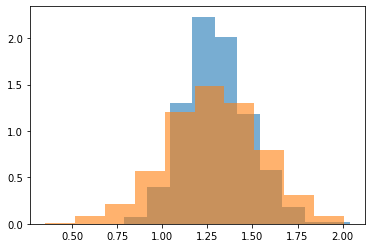

In [167]:
plt.hist(onp.array(sds), density=True, alpha=0.6)
plt.hist(onp.array(sds_new), density=True, label="new", alpha=0.6)

In [112]:
loss = -sd + l2 / 2
loss

DeviceArray(0.38619018, dtype=float32)

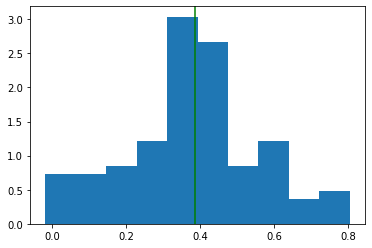

In [113]:
plt.hist(onp.array(ls), density=True);
plt.axvline(x=loss, color="green")

# load sweep csv

In [111]:
res = pd.read_csv('../experiments/results/bnn-sweep/best-stepsizes.csv', index_col=0)
res

,optimal_stepsize,max_val_accuracy
name,,
nvgd,1.000000e-07,0.125427


In [113]:
res['optimal_stepsize']['nvgd']

1e-07

## convnet shapes

In [73]:
shapes = []
def id_print(x):
    shapes.append(x.shape)
    print(f"Activation shape {x.shape}")
    return x

In [90]:
def model_fn(image):
    """returns logits"""
    n_channels = 8
    image = image.astype(jnp.float32)
    convnet = hk.Sequential([
#         hk.Conv2D(n_channels, kernel_shape=3),
#         jax.nn.relu,
#         id_print,

        hk.Conv2D(n_channels, kernel_shape=3, stride=2),
        jax.nn.relu,
        id_print,

#         hk.Conv2D(n_channels, kernel_shape=3),
#         jax.nn.relu,
#         id_print,

        hk.Conv2D(n_channels, kernel_shape=3, stride=2),
        jax.nn.relu,
        id_print,

        hk.Flatten(),
        id_print,
        hk.Linear(10),
    ])
    return convnet(image)

In [91]:
model = hk.without_apply_rng(hk.transform(model_fn))

In [92]:
imgs = random.normal(subkey, (128, 28, 28, 1))
params = model.init(subkey, imgs)

Activation shape (128, 14, 14, 8)
Activation shape (128, 7, 7, 8)
Activation shape (128, 392)


In [93]:
jax.flatten_util.ravel_pytree(params)[0].shape[0]

4594

In [88]:
utils.leaf_shapes(params)

FlatMapping({
  'conv2_d': FlatMapping({'b': (8,), 'w': (3, 3, 1, 8)}),
  'conv2_d_1': FlatMapping({'b': (8,), 'w': (3, 3, 8, 8)}),
  'conv2_d_2': FlatMapping({'b': (8,), 'w': (3, 3, 8, 8)}),
  'conv2_d_3': FlatMapping({'b': (8,), 'w': (3, 3, 8, 8)}),
  'linear': FlatMapping({'b': (10,), 'w': (392, 10)}),
})

In [89]:
activation_mem = sum([onp.prod(shape) for shape in shapes]) * 4 * 3
param_mem = jax.flatten_util.ravel_pytree(params)[0].shape[0] * 4

print("Activation memory:", activation_mem / 1e6, "MB")
print("Parameter memory:", param_mem / 1e6, "MB")

Activation memory: 39.588864 MB
Parameter memory: 0.023048 MB


In [83]:
# total MB
(activation_mem + param_mem) * 100 / 1e6

2394.1

# debugging new training

In [31]:
%autoreload

In [32]:
scale = 1
key, subkey = random.split(key)
xs = random.normal(subkey, (100, 5)) * scale


def logp(x):
    return norm.logpdf(x, loc=1, scale=3*scale).sum()


def logq(x):
    return norm.logpdf(x, scale=scale).sum()


def f(x):
    return (grad(logp)(x) - grad(logq)(x))


dlogp = vmap(grad(logp))(xs)

In [33]:
stein.stein_discrepancy(xs, logp, f)

DeviceArray(4.0054884, dtype=float32)

In [34]:
stein.stein_discrepancy_fixed_log(xs, dlogp, f)

DeviceArray(4.0054884, dtype=float32)

In [35]:
key, subkey = random.split(key)
stein.stein_discrepancy_hutchinson(subkey, xs, logp, f)

DeviceArray(3.5426853, dtype=float32)

In [36]:
stein.stein_discrepancy_hutchinson_fixed_log(subkey, xs, dlogp, f)

DeviceArray(3.5426853, dtype=float32)

# expectation of divergence

In [30]:
# q = N(0, 1)
# p = N(1, 4)
scale = 1
key, subkey = random.split(key)
xs = random.normal(subkey, (100, 5)) * scale


def logp(x):
    return norm.logpdf(x, loc=1, scale=3*scale).sum()


def logq(x):
    return norm.logpdf(x, scale=scale).sum()


def f(x):
    return (grad(logp)(x) - grad(logq)(x))


@partial(jit, static_argnums=1)
def expected_div(xs, f):
    def div(x):
        return jnp.trace(jacfwd(f)(x))
    return vmap(div)(xs).mean()


@partial(jit, static_argnums=(1, 2))
def expected_div_analytic(xs, f, logq):
    return -vmap(lambda x: jnp.inner(f(x), grad(logq)(x)))(xs).mean()

In [25]:
print(expected_div(xs, f))
print(expected_div_analytic(xs, f, logq))

4.4444437
4.319465


In [26]:
norm.logpdf(xs, scale=scale).sum()

DeviceArray(-704.53265, dtype=float32)

In [27]:
norm.logpdf(xs/scale).sum()

DeviceArray(-704.53265, dtype=float32)

In [63]:
def f_id(x):
    return x


key, subkey = random.split(key)
xs = random.normal(subkey, (100,15))

In [64]:
vmap(lambda x: jnp.inner(f_id(x), grad(logq)(x)))(xs).mean()

DeviceArray(-14.425682, dtype=float32)

# jax vs numpy indexing

In [3]:
import numpy as onp
arr = onp.arange(5)
idx = onp.array([1,2])
arr[idx]

array([1, 2])

In [4]:
import jax.numpy as jnp
j_idx = jnp.array([1,2])
arr[j_idx]

<ipython-input-4-9c09f5614663>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[j_idx]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## test utils.sgld

In [37]:
learning_rate = 1e-1
# opt = optax.sgd(learning_rate)
opt = utils.sgld(learning_rate)
# opt = utils.sgd(-learning_rate)

In [38]:
def loss(x):
    return x**2

In [39]:
x = 100.
state = opt.init(x)
ls = []
xs = []
for _ in range(10):
    l, g = value_and_grad(loss)(x)
    g, state = opt.update(g, state, x)
    x = optax.apply_updates(x, g)
    ls.append(l)
    xs.append(x)

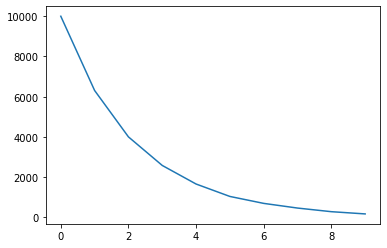

In [40]:
plt.plot(ls)

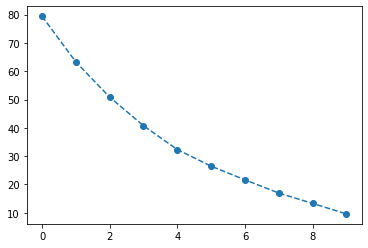

In [41]:
plt.plot(xs, "--o")

## Bad jax error message

In [5]:
@partial(jit, static_argnums=1)
def f(x, y=0, z=0):
    return x + y - z

f(5, 3)

DeviceArray(8, dtype=int32)

In [6]:
f(5)

ValueError: jitted function has static_argnums=(1,), donate_argnums=() but was called with only 1 positional arguments.

In [7]:
f(x=5, y=3)

ValueError: jitted function has static_argnums=(1,), donate_argnums=() but was called with only 0 positional arguments.

# remove diagonal
(utility function broken by jax update)

In [32]:
@jit
def offdiagonal_idx(matrix):
    n = matrix.shape[0]
    return onp.nonzero(~onp.eye(n, dtype=bool))

In [33]:
offdiagonal_idx(random.normal(subkey, (3,3)))

(DeviceArray([0, 0, 1, 1, 2, 2], dtype=int32),
 DeviceArray([1, 2, 0, 2, 0, 1], dtype=int32))

In [34]:
def remove_diagonal_old(matrix):
    """matrix is an (n,n) array.
    ouput: (n, n-1) array, matrix without the diagonal"""
    n = matrix.shape[0]
    idx = np.ones((n, n))
    idx = utils.null_diagonal(idx)
    return matrix[idx.nonzero()].reshape((n, n-1))

In [35]:
@jit
def remove_diagonal(matrix):
    n = matrix.shape[0]
    idx = offdiagonal_idx(matrix)
    return matrix[idx].reshape(n, n-1)

In [36]:
matrix = random.normal(subkey, (3,3))

In [38]:
remove_diagonal(matrix)

DeviceArray([[-0.04487171, -2.0427265 ],
             [ 0.07932303,  0.79599744],
             [-1.4411981 , -1.6929983 ]], dtype=float32)

# polynomial schedules

In [222]:
NUM_STEPS = 100

In [225]:
%autoreload

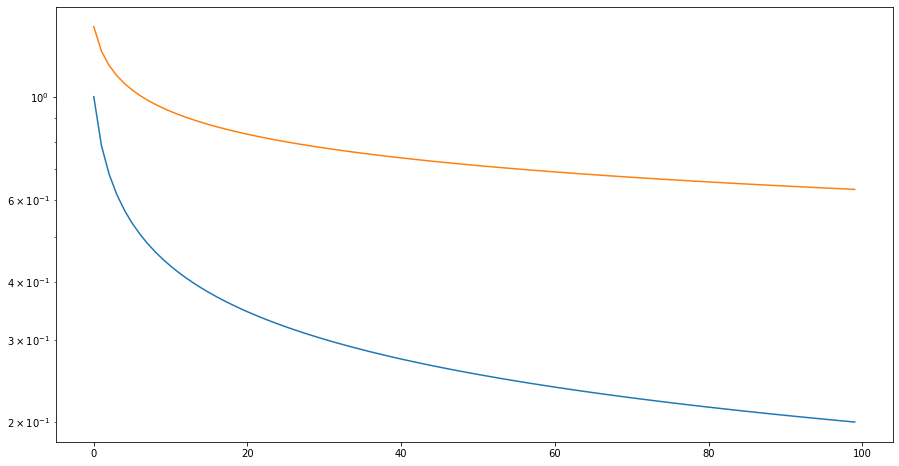

In [227]:
%matplotlib inline
plt.subplots(figsize=[15, 8])
plt.plot([utils.polynomial_schedule(step) for step in range(NUM_STEPS)])
plt.plot([np.sqrt(2*utils.polynomial_schedule(step)) for step in range(NUM_STEPS)])
plt.yscale("log")
# plt.ylim(1e-2, 2e-1)

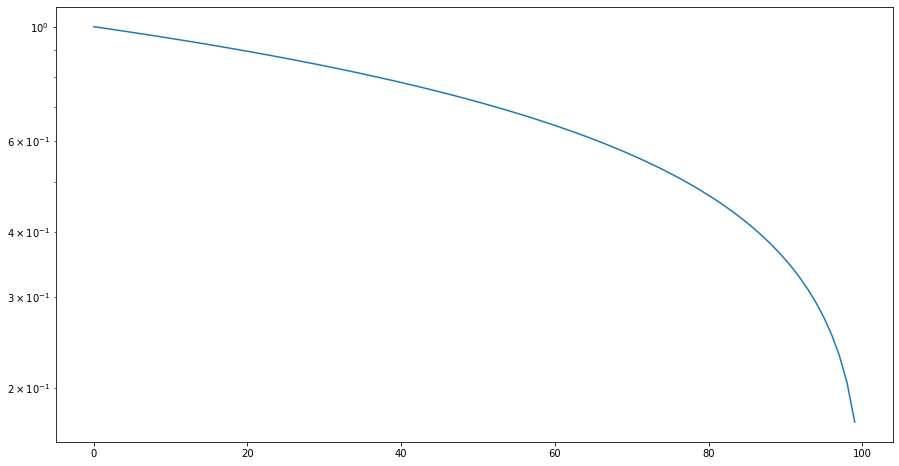

In [220]:
s = optax.polynomial_schedule(1, 1e-1, .55, 100)
%matplotlib inline
plt.subplots(figsize=[15, 8])
plt.plot([s(step) for step in range(NUM_STEPS)])
plt.yscale("log")

# Testing SGLD

In [204]:
setup = distributions.funnel
target, proposal = setup.get()
lr = 1e-3
n_steps = 500

kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target.logpdf, step_size=lr)

@jit
def run_chain(key, state):
    return tfp.mcmc.sample_chain(n_steps,
      current_state=state,
      kernel=kernel,
      trace_fn = None,
      num_burnin_steps=0,
      seed=key)

In [210]:
key, subkey = random.split(key)
state = proposal.sample(100, subkey)[0]
p1 = run_chain(subkey, state)

key, subkey = random.split(key)
grad, particles, err = flows.sgld_flow(subkey, setup, n_particles=1, n_steps=n_steps, particle_lr=lr)
p2 = np.squeeze(particles.rundata["particles"].training)

100%|██████████| 500/500 [00:01<00:00, 261.44it/s]


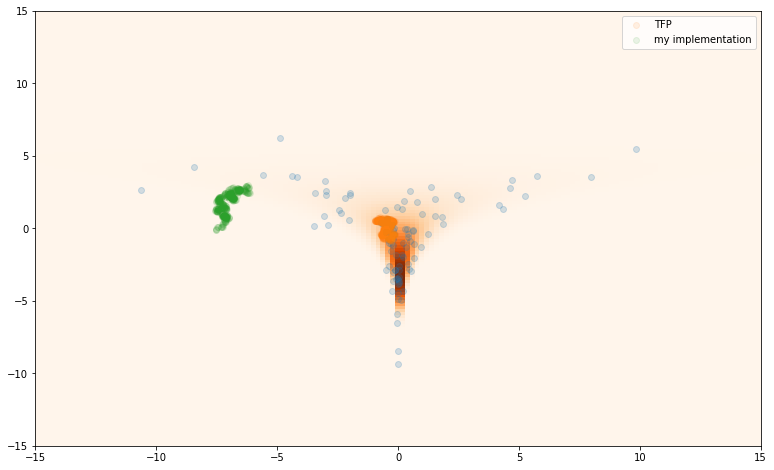

In [211]:
fig, ax = plt.subplots(figsize=[13, 8])
ax.set(xlim=(-15, 15), ylim=(-15, 15))
plot.plot_fun_2d(target.pdf, lims=(-15,15))

key, subkey = random.split(key)
plt.scatter(*np.rollaxis(target.sample(100, subkey), 1), alpha=0.2)

plot.scatter(p1, alpha=0.1, label="TFP")
plot.scatter(p2, alpha=0.1, label="my implementation")
plt.legend()

### same thing but parallel

In [212]:
n_particles = 100
key, subkey = random.split(key)
grad, particles, err = flows.sgld_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=lr)

key, subkey = random.split(key)
state = proposal.sample(n_particles, subkey)
pp1 = vmap(run_chain)(random.split(subkey, n_particles), state)
pp2 = particles.rundata["particles"].training

100%|██████████| 500/500 [00:02<00:00, 202.80it/s]


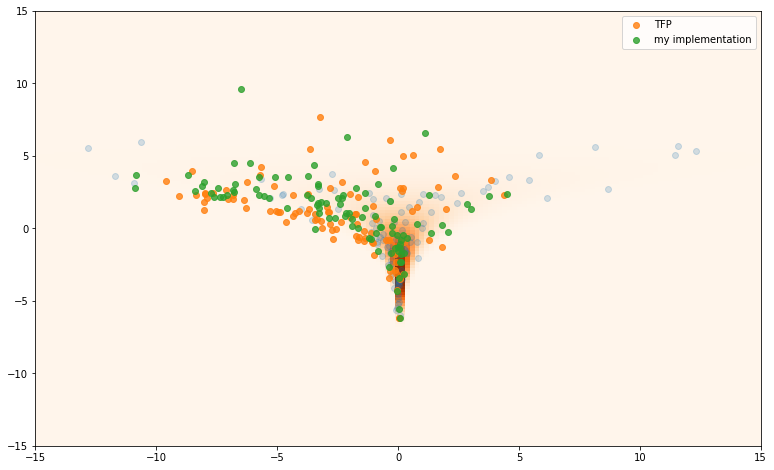

In [213]:
fig, ax = plt.subplots(figsize=[13, 8])
ax.set(xlim=(-15, 15), ylim=(-15, 15))
plot.plot_fun_2d(target.pdf, lims=(-15,15))

key, subkey = random.split(key)
plt.scatter(*np.rollaxis(target.sample(100, subkey), 1), alpha=0.2)

plot.scatter(pp1[:, -1, :], alpha=0.8, label="TFP")
plot.scatter(pp2[-1], alpha=0.8, label="my implementation")
plt.legend()

# SGLD optax optimizer

In [91]:
%autoreload

In [92]:
# opt = utils.polynomial_sgld(1.)
opt = utils.scaled_sgld(subkey, 1., utils.polynomial_schedule)

In [93]:
params = np.array(100.)
state = opt.init(params)
grads = np.array(0.)

p = []
u = []
for _ in range(1000):
    updates, state = opt.update(grads, state)
    params = optax.apply_updates(params, updates)
    p.append(params)
    u.append(updates)

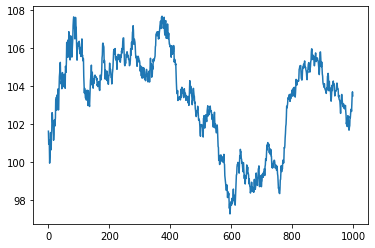

In [94]:
plt.plot(p)

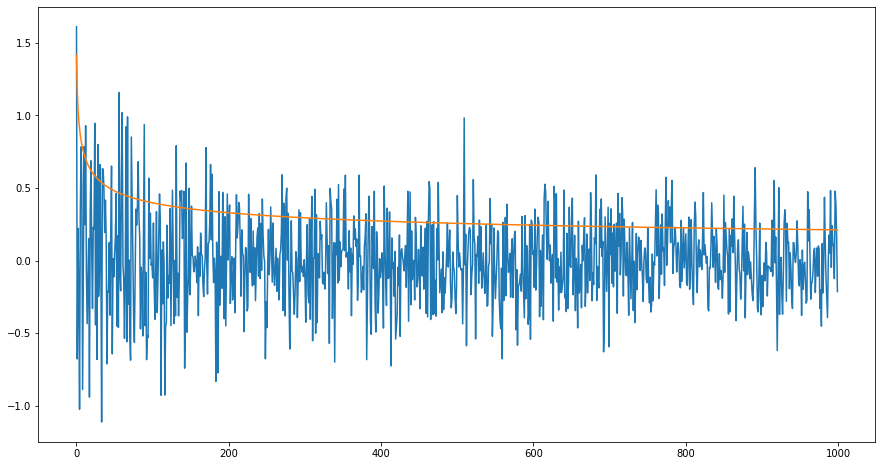

In [95]:
plt.subplots(figsize=[15, 8])
plt.plot(u)
plt.plot([np.sqrt(2*utils.polynomial_schedule(k)) for k in range(1000)])

In [96]:
np.mean(np.array(u))

DeviceArray(0.00347712, dtype=float32)

In [85]:
np.var(np.array(u))

DeviceArray(0.09306009, dtype=float32)